Spatial Interpolation Tutorial
Source: https://pygis.io/docs/e_interpolation.html 

In [1]:
# Import modules
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pykrige.ok import OrdinaryKriging
import rasterio
import rasterio.mask
from rasterio.plot import show
from rasterio.transform import Affine
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import box
from shapely.geometry import Polygon, Point
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

In [2]:
# Load data
# County boundaries
# Source: https://earthworks.stanford.edu/catalog/stanford-jm667wq2232
counties = gpd.read_file("data/cacounties.json")

# Depth to Groundwater Spring 2012 
# Source: https://earthworks.stanford.edu/catalog/stanford-pp561fb8417

groundwater = gpd.read_file("data/stanfordgroundwater2012.json")

# Reproject data to CA Teale Albert
# https://nrm.dfg.ca.gov/FileHandler.ashx?DocumentID=109326&inline
proj = "+proj=aea +lat_1=34 +lat_2=40.5 +lat_0=0 +lon_0=-120 +x_0=0 +y_0=-4000000 +ellps=GRS80 +datum=NAD83 +units=m +no_defs "
counties = counties.to_crs(proj)
groundwater = groundwater.to_crs(proj)

In [3]:
# Get X and Y coordinates of rainfall points
x_water = groundwater["geometry"].x
y_water = groundwater["geometry"].y

# Create list of XY coordinate pairs
coords_rain = [list(xy) for xy in zip(x_water, y_water)]

# Get extent of counties feature
min_x_counties, min_y_counties, max_x_counties, max_y_counties = counties.total_bounds

# Get list of rainfall "values"
value_water = list(groundwater["dgbs"])

# Create a copy of counties dataset
counties_dissolved = counties.copy()

# Add a field with constant value of 1
counties_dissolved["constant"] = 1

# Dissolve all counties to create one polygon
counties_dissolved = counties_dissolved.dissolve(by = "constant").reset_index(drop = True)

In [4]:
def export_kde_raster(Z, XX, YY, min_x, max_x, min_y, max_y, proj, filename):
    '''Export and save a kernel density raster.'''

    # Get resolution
    xres = (max_x - min_x) / len(XX)
    yres = (max_y - min_y) / len(YY)

    # Set transform
    transform = Affine.translation(min_x - xres / 2, min_y - yres / 2) * Affine.scale(xres, yres)

    # Export array as raster
    with rasterio.open(
            filename,
            mode = "w",
            driver = "GTiff",
            height = Z.shape[0],
            width = Z.shape[1],
            count = 1,
            dtype = Z.dtype,
            crs = proj,
            transform = transform,
    ) as new_dataset:
            new_dataset.write(Z, 1)

In [5]:
# Split data into testing and training sets
coords_rain_train, coords_rain_test, value_rain_train, value_rain_test = train_test_split(coords_rain, value_water, test_size = 0.20, random_state = 42)

# Create separate GeoDataFrames for testing and training sets
rain_train_gdf = gpd.GeoDataFrame(geometry = [Point(x, y) for x, y in coords_rain_train], crs = proj)
rain_train_gdf["Actual_Value"] = value_rain_train
rain_test_gdf = gpd.GeoDataFrame(geometry = [Point(x, y) for x, y in coords_rain_test], crs = proj)
rain_test_gdf["Actual_Value"] = value_rain_test

# Get minimum and maximum coordinate values of rainfall training points
min_x_rain, min_y_rain, max_x_rain, max_y_rain = rain_train_gdf.total_bounds

Text(0.5, 1.0, 'California Groundwater Measurement Locations')

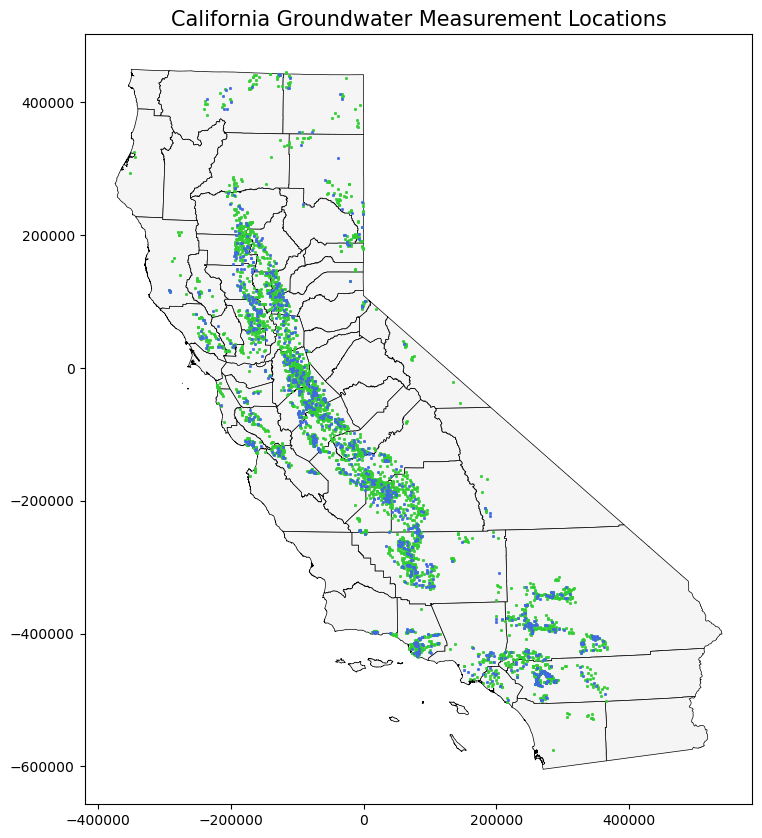

In [6]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

# Stylize plots
plt.style.use('bmh')

# Plot data
counties.plot(ax = ax, color = 'whitesmoke', edgecolor = 'black')
rain_train_gdf.plot(ax = ax, marker = 'o', color = 'limegreen', markersize = 3)
rain_test_gdf.plot(ax = ax, marker = 'o', color = 'royalblue', markersize = 3)
# Set title
ax.set_title('California Groundwater Measurement Locations', fontdict = {'fontsize': '15', 'fontweight' : '3'})

---

Thiessen (Voronoi)

---


In [7]:
# Extend extent of counties feature by using buffer
counties_buffer = counties.buffer(100000)

# Get extent of buffered input feature
min_x_cty_tp, min_y_cty_tp, max_x_cty_tp, max_y_cty_tp = counties_buffer.total_bounds

# Use extent to create dummy points and add them to list of coordinates
coords_tp = coords_rain_train + [[min_x_cty_tp, min_y_cty_tp], [max_x_cty_tp, min_y_cty_tp],
                                 [max_x_cty_tp, max_y_cty_tp], [min_x_cty_tp, max_y_cty_tp]]

# Compute Voronoi diagram
tp = Voronoi(coords_tp)

# Create empty list of hold Voronoi polygons
tp_poly_list = []

# Create a polygon for each region
# 'regions' attribute provides a list of indices of the vertices (in the 'vertices' attribute) that make up the region
# Source: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Voronoi.html
for region in tp.regions:

    # Ignore region if -1 is in the list (based on documentation)
    if -1 in region:

        # Return to top of loop
        continue

    # Otherwise, pass
    else:
        pass

    # Check that region list has values in it
    if len(region) != 0:

        # Create a polygon by using the region list to call the correct elements in the 'vertices' attribute
        tp_poly_region = Polygon(list(tp.vertices[region]))

        # Append polygon to list
        tp_poly_list.append(tp_poly_region)

    # If no values, return to top of loop
    else:
        continue

# Create GeoDataFrame from list of polygon regions
tp_polys = gpd.GeoDataFrame(tp_poly_list, columns = ['geometry'], crs = proj)

# Clip polygon regions to the counties boundary
tp_polys_clipped = gpd.clip(tp_polys, counties_dissolved)

In [8]:
# If rainfall point within the polygon, assign that rainfall value to the polygon
tp_polys_clipped_values = gpd.sjoin(rain_train_gdf, tp_polys_clipped, how = "right", op = 'within')

# Drop un-needed column
tp_polys_clipped_values = tp_polys_clipped_values.drop("index_left", axis = 1)

# Rename column
tp_polys_clipped_values = tp_polys_clipped_values.rename(columns = {"Actual_Value": "VALUE_Thiessen"})

# Display head of attribute table
print("Attribute Table: Thiessen Polygon Interpolated Values")
display(tp_polys_clipped_values.head())

Attribute Table: Thiessen Polygon Interpolated Values


/home/abbyhildebrandt/miniconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,VALUE_Thiessen,geometry
233,8.65,"MULTIPOLYGON (((332223.830 -572517.492, 349363..."
10,24.45,"POLYGON ((242935.814 -524007.636, 212036.645 -..."
496,50.01,"POLYGON ((235760.822 -486722.157, 237971.177 -..."
247,23.45,"MULTIPOLYGON (((190373.187 -477876.666, 192820..."
495,14.25,"POLYGON ((199188.686 -481041.857, 199377.150 -..."


In [9]:
# If test point is within a polygon, assign that polygon's value to the test point
rain_test_pred_tp = gpd.sjoin(rain_test_gdf, tp_polys_clipped_values, how = "left", op = 'within')

# Drop un-needed column
rain_test_pred_tp = rain_test_pred_tp.drop("index_right", axis = 1)

# Rename column
rain_test_pred_tp = rain_test_pred_tp.rename(columns = {"Actual_Value": "VALUE_Actual", "VALUE_Thiessen": "VALUE_Predict"})

# Generate out-of-sample R^2
out_r_squared_tp = r2_score(rain_test_pred_tp.VALUE_Actual, rain_test_pred_tp.VALUE_Predict)
print("Thiessen polygon out-of-sample r-squared: {}".format(round(out_r_squared_tp, 2)))

# Display attribute table
print("\nAttribute Table: Testing Dataset Interpolated Values - Thiessen Polygon Method")
display(rain_test_pred_tp.head(2))

Thiessen polygon out-of-sample r-squared: 0.64

Attribute Table: Testing Dataset Interpolated Values - Thiessen Polygon Method


/home/abbyhildebrandt/miniconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,geometry,VALUE_Actual,VALUE_Predict
0,POINT (-108030.735 -53225.022),143.97,116.95
1,POINT (-87636.960 -80388.861),6.70,3.60


Text(0.5, 1.0, 'California Groundwater Values - Testing Locations & Thiessen Polygons')

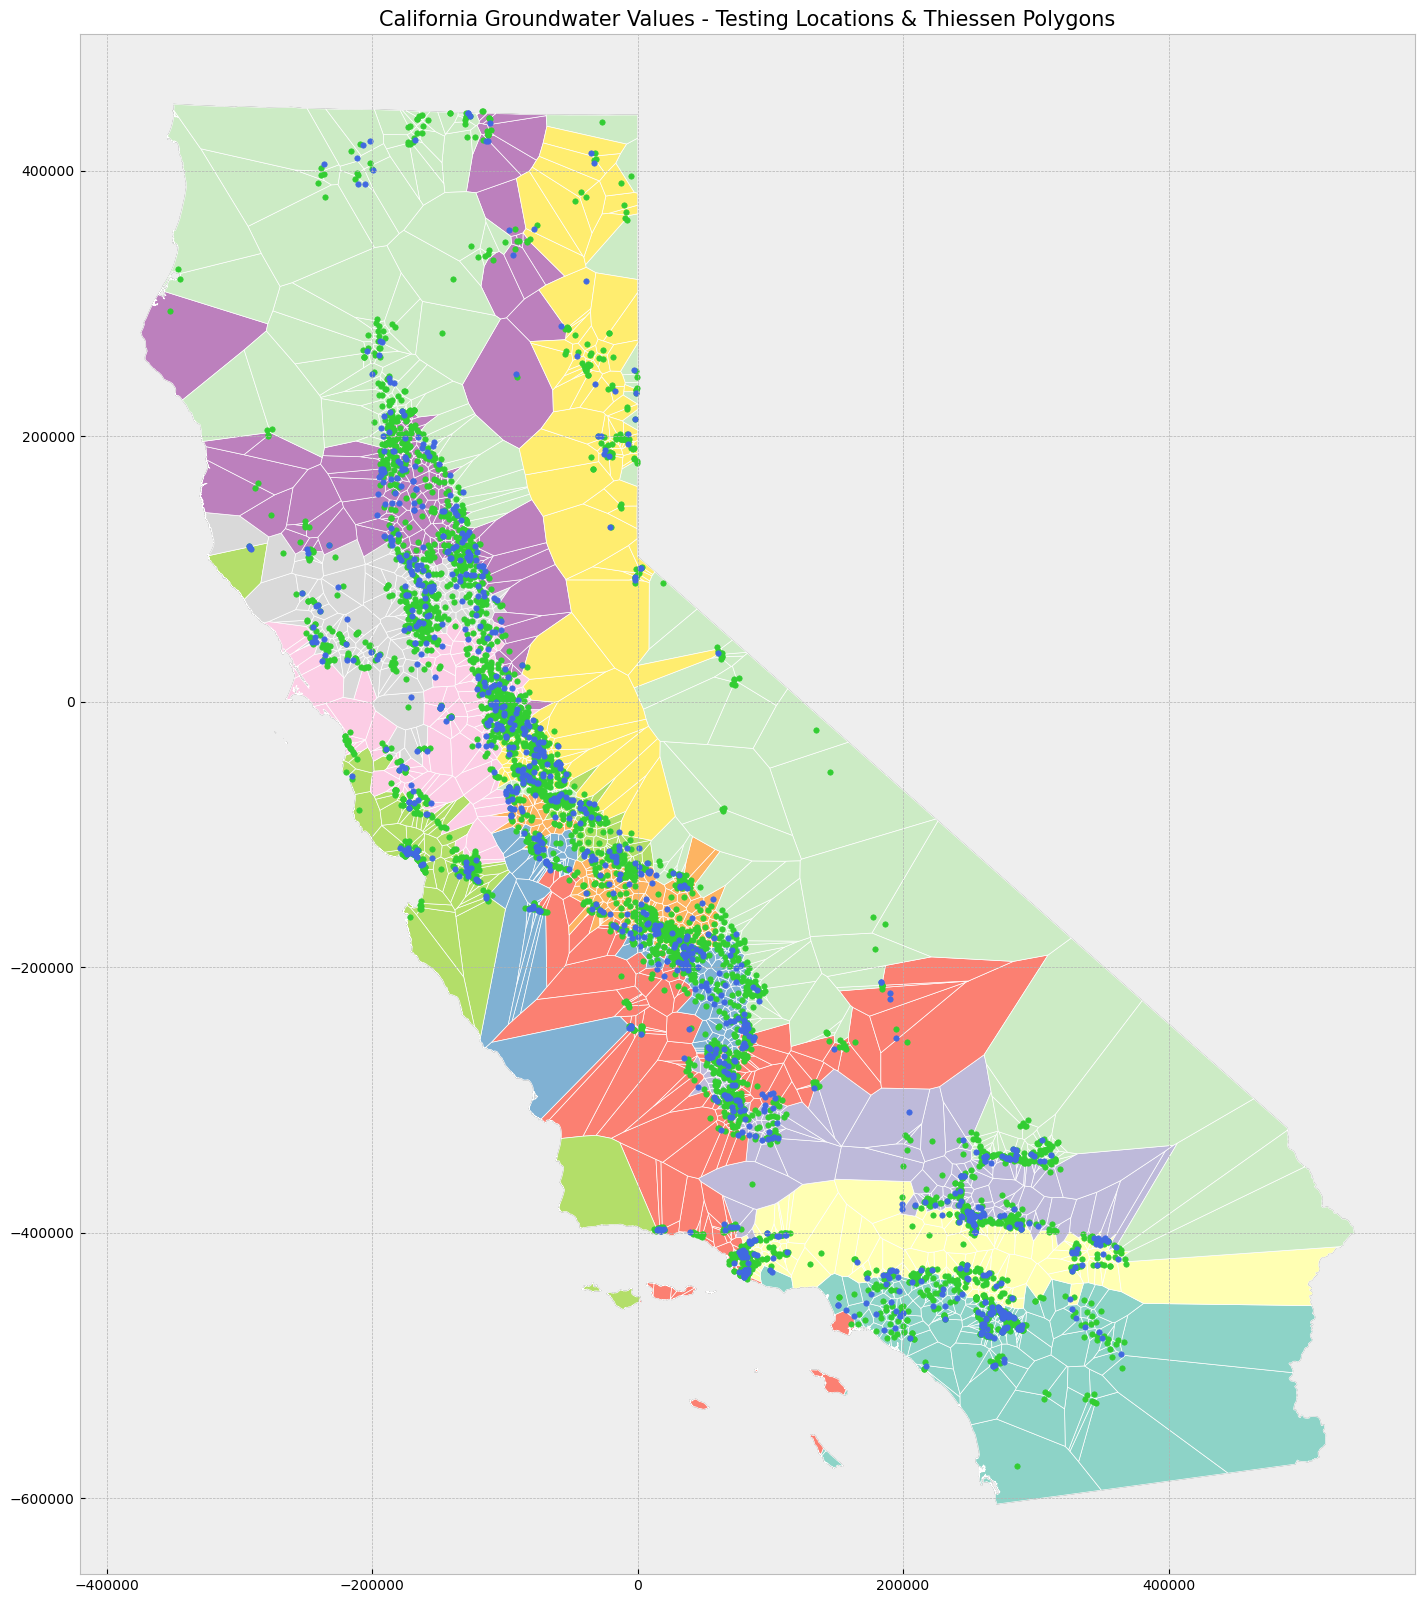

In [12]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (20, 20))

# Stylize plots
plt.style.use('bmh')

# Plot data
counties_dissolved.plot(ax = ax, color = 'none', edgecolor = 'dimgray')
tp_polys_clipped.plot(ax = ax, cmap = 'Set3', edgecolor = 'white', linewidth = 0.5)
rain_train_gdf.plot(ax = ax, marker = 'o', color = 'limegreen', markersize = 15)
rain_test_pred_tp.plot(ax = ax, marker = 'o', color = 'royalblue', markersize = 15)

# Iterate through each rainfall train point to add a label with its value to the plot
#for index, row in rain_train_gdf.iterrows():
 #   plt.annotate(row.Actual_Value, (row.geometry.x, row.geometry.y))

# Iterate through each rainfall test point to add a label with its value to the plot
#for index, row in rain_test_pred_tp.iterrows():
 #   plt.annotate(row.VALUE_Predict, (row.geometry.x, row.geometry.y))

# Set title
ax.set_title('California Groundwater Values - Testing Locations & Thiessen Polygons', fontdict = {'fontsize': '15', 'fontweight' : '3'})

In [13]:
# Set index for feature of interest
feature_index_one = 5

# Get a Voronoi polygon for one feature
# 'point_region' attribute provides the index of the Voronoi region belonging to a specified point
# Can use the index to call the appropriate element in the 'regions' attribute
tp_poly_region_one = Polygon(tp.vertices[tp.regions[tp.point_region[feature_index_one]]])

# Create GeoDataFrame for polygon
tp_poly_region_one = gpd.GeoDataFrame([tp_poly_region_one], columns = ['geometry'], crs = proj)

# Clip polygon to county boundary
tp_poly_region_one = gpd.clip(tp_poly_region_one, counties_dissolved)

# Get the equivalent feature from the rainfall dataset
rain_one = rain_train_gdf.iloc[[feature_index_one]]

# Add the rainfall value to the polygon attribute table
tp_poly_region_one["VALUE_Predict"] = rain_one["Actual_Value"].values

# Display attribute table
print("Attribute Table: Thiessen Polygon Interpolated Value")
display(tp_poly_region_one)

Attribute Table: Thiessen Polygon Interpolated Value


,geometry,VALUE_Predict
0,"POLYGON ((-1212.421 97452.098, 1194.718 99371....",34.89


Text(0.5, 1.0, 'California Groundwater - One Point and Thiessen Polygon')

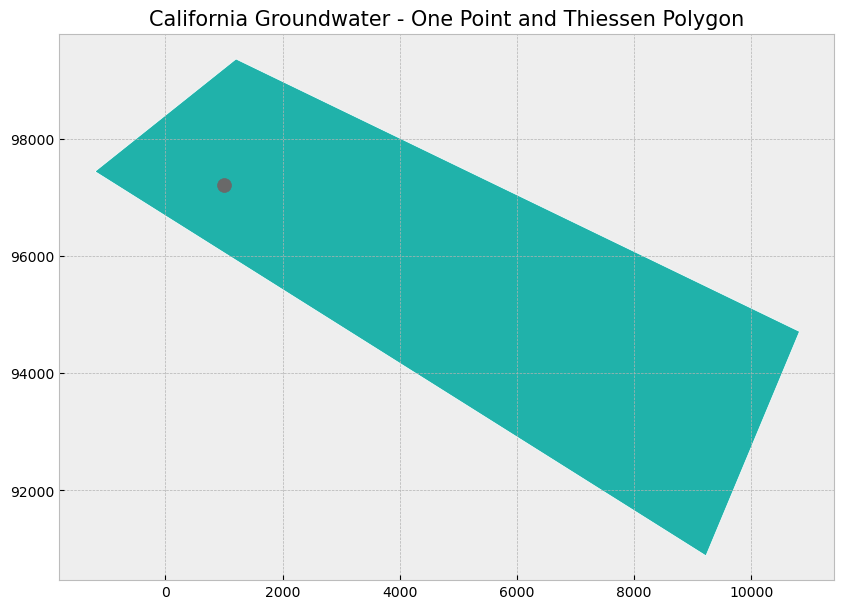

In [15]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

# Stylize plots
plt.style.use('bmh')

# Plot data
tp_poly_region_one.plot(ax = ax, color = 'lightseagreen', edgecolor = 'white', linewidth = 0.5)
rain_one.plot(ax = ax, marker = 'o', color = 'dimgray', markersize = 100)

# Set title
ax.set_title('California Groundwater - One Point and Thiessen Polygon', fontdict = {'fontsize': '15', 'fontweight' : '3'})

---

K- Nearest Neighbor

---

In [16]:
# Set number of neighbors to look for
neighbors = 5

# Initialize KNN regressor
knn_regressor = KNeighborsRegressor(n_neighbors = neighbors, weights = "distance")

# Fit regressor to data
knn_regressor.fit(coords_rain_train, value_rain_train)

KNeighborsRegressor(weights='distance')

In [17]:
# Generate in-sample R^2
in_r_squared_knn = knn_regressor.score(coords_rain_train, value_rain_train)
print("KNN in-sample r-squared: {}".format(round(in_r_squared_knn, 2)))

KNN in-sample r-squared: 0.99
